## MNIST CNN

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

### Data

In [3]:
path = untar_data(URLs.MNIST)

In [4]:
path.ls()

[PosixPath('/Users/anuragsharma/.fastai/data/mnist_png/training'),
 PosixPath('/Users/anuragsharma/.fastai/data/mnist_png/testing')]

In [5]:
il = ImageList.from_folder(path, convert_mode='L')

In [6]:
il.items[0]

PosixPath('/Users/anuragsharma/.fastai/data/mnist_png/training/9/36655.png')

In [7]:
defaults.cmap='binary'

In [8]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /Users/anuragsharma/.fastai/data/mnist_png

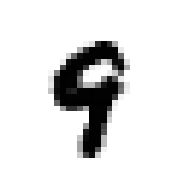

In [9]:
il[0].show()

In [10]:
sd = il.split_by_folder(train='training', valid='testing')

In [11]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /Users/anuragsharma/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /Users/anuragsharma/.fastai/data/mnist_png;

Test: None

In [12]:
(path/'training').ls()

[PosixPath('/Users/anuragsharma/.fastai/data/mnist_png/training/9'),
 PosixPath('/Users/anuragsharma/.fastai/data/mnist_png/training/0'),
 PosixPath('/Users/anuragsharma/.fastai/data/mnist_png/training/7'),
 PosixPath('/Users/anuragsharma/.fastai/data/mnist_png/training/6'),
 PosixPath('/Users/anuragsharma/.fastai/data/mnist_png/training/1'),
 PosixPath('/Users/anuragsharma/.fastai/data/mnist_png/training/8'),
 PosixPath('/Users/anuragsharma/.fastai/data/mnist_png/training/4'),
 PosixPath('/Users/anuragsharma/.fastai/data/mnist_png/training/3'),
 PosixPath('/Users/anuragsharma/.fastai/data/mnist_png/training/2'),
 PosixPath('/Users/anuragsharma/.fastai/data/mnist_png/training/5')]

In [13]:
ll = sd.label_from_folder()

In [14]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
9,9,9,9,9
Path: /Users/anuragsharma/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
9,9,9,9,9
Path: /Users/anuragsharma/.fastai/data/mnist_png;

Test: None

In [15]:
x,y = ll.train[0]

9 torch.Size([1, 28, 28])


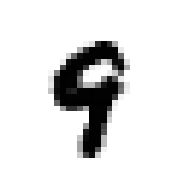

In [16]:
x.show()
print(y,x.shape)

In [17]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [18]:
ll = ll.transform(tfms)

In [19]:
bs = 128

In [20]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [21]:
x,y = data.train_ds[0]

9


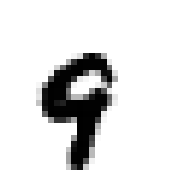

In [22]:
x.show()
print(y)

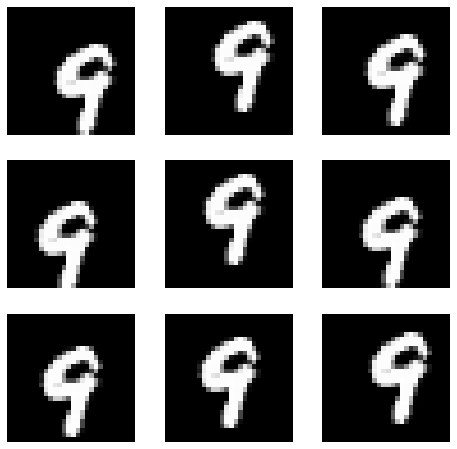

In [23]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [24]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

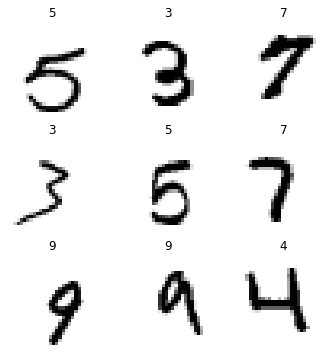

In [25]:
data.show_batch(rows=3, figsize=(5,5))

### Basic CNN with batchnorm

In [26]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [27]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [28]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [29]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [30]:
xb = xb

In [31]:
model(xb).shape

torch.Size([128, 10])

In [32]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


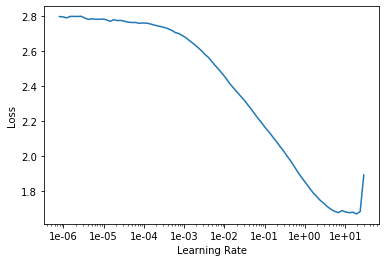

In [33]:
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.220490,0.207853,0.930700,00:35
1,0.132654,0.078407,0.975900,00:32
2,0.074928,0.038058,0.987300,00:33


### Refactor

In [35]:
conv_layer??

In [36]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2,padding=1)

In [37]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [38]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [39]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.224084,0.152761,0.950700,00:28
1,0.187523,0.182317,0.941800,00:28
2,0.160369,0.129559,0.956600,00:32
3,0.145830,0.124327,0.962500,00:30
4,0.121846,0.082094,0.973700,00:31
5,0.097829,0.061726,0.979600,00:33
6,0.082429,0.055915,0.981500,00:36
7,0.060236,0.046389,0.985700,00:29
8,0.047531,0.029946,0.990700,00:26
9,0.044258,0.028114,0.991400,00:26


### Resnet-ish

In [40]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [54]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense: bool = False, norm_type: Union[fastai.layers.NormType, NoneType] = <NormType.Batch: 1>, bottle: bool = False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [45]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [63]:
# def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), ResBlock(nf))

In [64]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [65]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


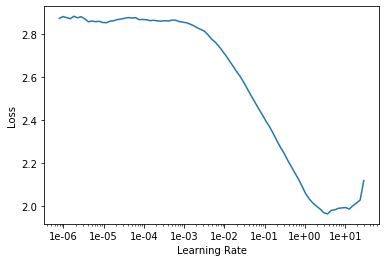

In [66]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [50]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.192001,0.127039,0.963100,00:54
1,0.126624,0.130480,0.960000,00:57
2,0.113793,0.101628,0.969500,00:57
3,0.088953,0.198598,0.935100,00:54
4,0.074419,0.141972,0.954200,00:54
5,0.058232,0.048097,0.983400,01:02
6,0.052287,0.053752,0.983200,00:55
7,0.044489,0.038133,0.988300,00:55
8,0.037698,0.025081,0.991700,00:46
9,0.024128,0.018741,0.993800,00:46


In [51]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________

In [67]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.190221,0.134321,0.960800,00:53
1,0.120036,0.125614,0.961300,00:55
2,0.108444,0.130325,0.956600,01:00
3,0.092631,0.096245,0.971000,00:55
4,0.075689,0.076559,0.975900,00:55
5,0.060529,0.145805,0.955100,00:54
6,0.049686,0.043576,0.986900,00:50
7,0.039393,0.027660,0.991400,00:51
8,0.034047,0.023081,0.993100,00:54
9,0.024658,0.017684,0.994200,00:55


In [68]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________

## fin